# 03. Sport pitches lines Semantic Segmentation

## 1. Imports & variables

In [1]:
import cv2
import torch
import random
import pickle
import pathlib
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from torchvision import models
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"
mode = "inference" # inference || train

## 2. Loading Dataset

In [2]:
class SportPitchesDataset(Dataset):
    def __init__(self, path, transforms):
        super().__init__()
        self.img_paths = list(pathlib.Path(f"{path}/img").glob("*.png"))
        self.mask_paths = list(pathlib.Path(f"{path}/mask").glob("*.png"))
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(str(self.img_paths[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[index]), cv2.IMREAD_GRAYSCALE)
        a = self.transforms(image=image, mask=mask)
        return T.ToTensor()(a['image']), torch.from_numpy(a['mask']/255).long()

In [3]:
data_transform = A.Compose([A.Resize(720, 1280)])

train_set = SportPitchesDataset(path="./datasets/final/train", transforms=data_transform)
val_set = SportPitchesDataset(path="./datasets/final/val", transforms=data_transform)
test_set = SportPitchesDataset(path="./datasets/final/test", transforms=data_transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=True, drop_last=True)

## 3. PSPNET Model Implementation

In [4]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)

        return x, auxiliary_x

In [5]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels, int(in_channels / len(pools)), 1, 1, 0, 1, bias=False),
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [6]:
class SegmentationClassifier(nn.Module):

    def __init__(self, in_channels, out_channels, upsample_count):
        super().__init__()
        self.upsample_count = upsample_count
        self.initial_upsample = self._upsample_layer(in_channels, out_channels)
        self.final_upsample = self._upsample_layer(out_channels, out_channels)

    def _upsample_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.UpsamplingBilinear2d(scale_factor=2),
        )

    def forward(self, x):
        for i in range(self.upsample_count):
            x = self.initial_upsample(x) if i == 0 else self.final_upsample(x)
        return x

In [7]:
class PSPNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(int(input_shape[0] / 8), int(input_shape[1] / 8)), in_channels=512, pools = (6, 3, 2, 1))
        self.classifier = SegmentationClassifier(in_channels=1024, out_channels=n_classes, upsample_count=3)
        self.aux_classifier = SegmentationClassifier(in_channels=256, out_channels=n_classes, upsample_count=2)

    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        return self.classifier(pyramid_outputs), self.aux_classifier(encoder_auxiliary)

In [8]:
model = PSPNet(input_shape=(720, 1280), n_classes=2)
model.load_state_dict(torch.load("./models/03_pspnet_final_model_1.pth"))
summary(model, input_size=(3, 3, 720, 1280))

Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 2, 720, 1280]         --
├─CustomResNet: 1-1                                [3, 512, 90, 160]         --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 360, 640]         9,408
│    │    └─BatchNorm2d: 3-2                       [3, 64, 360, 640]         128
│    │    └─ReLU: 3-3                              [3, 64, 360, 640]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 180, 320]         --
│    │    └─Sequential: 3-5                        [3, 256, 180, 320]        215,808
│    │    └─Sequential: 3-6                        [3, 512, 90, 160]         1,219,584
├─PyramidPoolingModule: 1-2                        [3, 1024, 90, 160]        --
│    └─ModuleList: 2-2                             --                        --
│    │    └

## 4. Training

In [9]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, output, aux_output, target):
        loss = self.cross_entropy(output, target)
        aux_loss = self.cross_entropy(aux_output, target)
        return loss + self.alpha * aux_loss

In [10]:
criterion = DeepSupervisionLoss(alpha=0.4)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)

In [11]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [12]:
def load_history(filename):
    with open(filename, 'rb') as file:
        history = pickle.load(file)
        return history['train_loss'], history['val_loss'], history['train_accuracy'], history['val_accuracy']

In [13]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    for e in tqdm(range(epochs)):
        epoch_train_loss = []
        epoch_train_accuracy = []
        epoch_val_loss = []
        epoch_val_accuracy = []

        model.train()
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask.to(device)
            output, aux_output = model(img)
            loss = criterion(output, aux_output, mask)
            epoch_train_loss.append(loss.cpu().detach().numpy())
            epoch_train_accuracy.append(pixel_accuracy(output, mask))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask.to(device)
                output, aux_output = model(img)
                loss = criterion(output, aux_output, mask)
                epoch_val_loss.append(loss.cpu().detach().numpy())
                epoch_val_accuracy.append(pixel_accuracy(output, mask))

        train_loss.append(np.mean(epoch_train_loss))
        train_accuracy.append(np.mean(epoch_train_accuracy))
        val_loss.append(np.mean(epoch_val_loss))
        val_accuracy.append(np.mean(epoch_val_accuracy))

        print(f"Epoch {e} | Loss: {np.mean(epoch_train_loss):.5f} | Val Loss : {np.mean(epoch_val_loss):.5f} | Accuracy: {np.mean(epoch_train_accuracy):.5f} | Val Accuracy: {np.mean(epoch_val_accuracy):.5f}")

    return train_loss, val_loss, train_accuracy, val_accuracy

In [14]:
train_loss, val_loss, train_accuracy, val_accuracy = fit(10, model, train_loader, val_loader, criterion, optimizer) if mode == "train" else load_history("./models/03_pspnet_final_history_1.pkl")

# 5. Evaluating

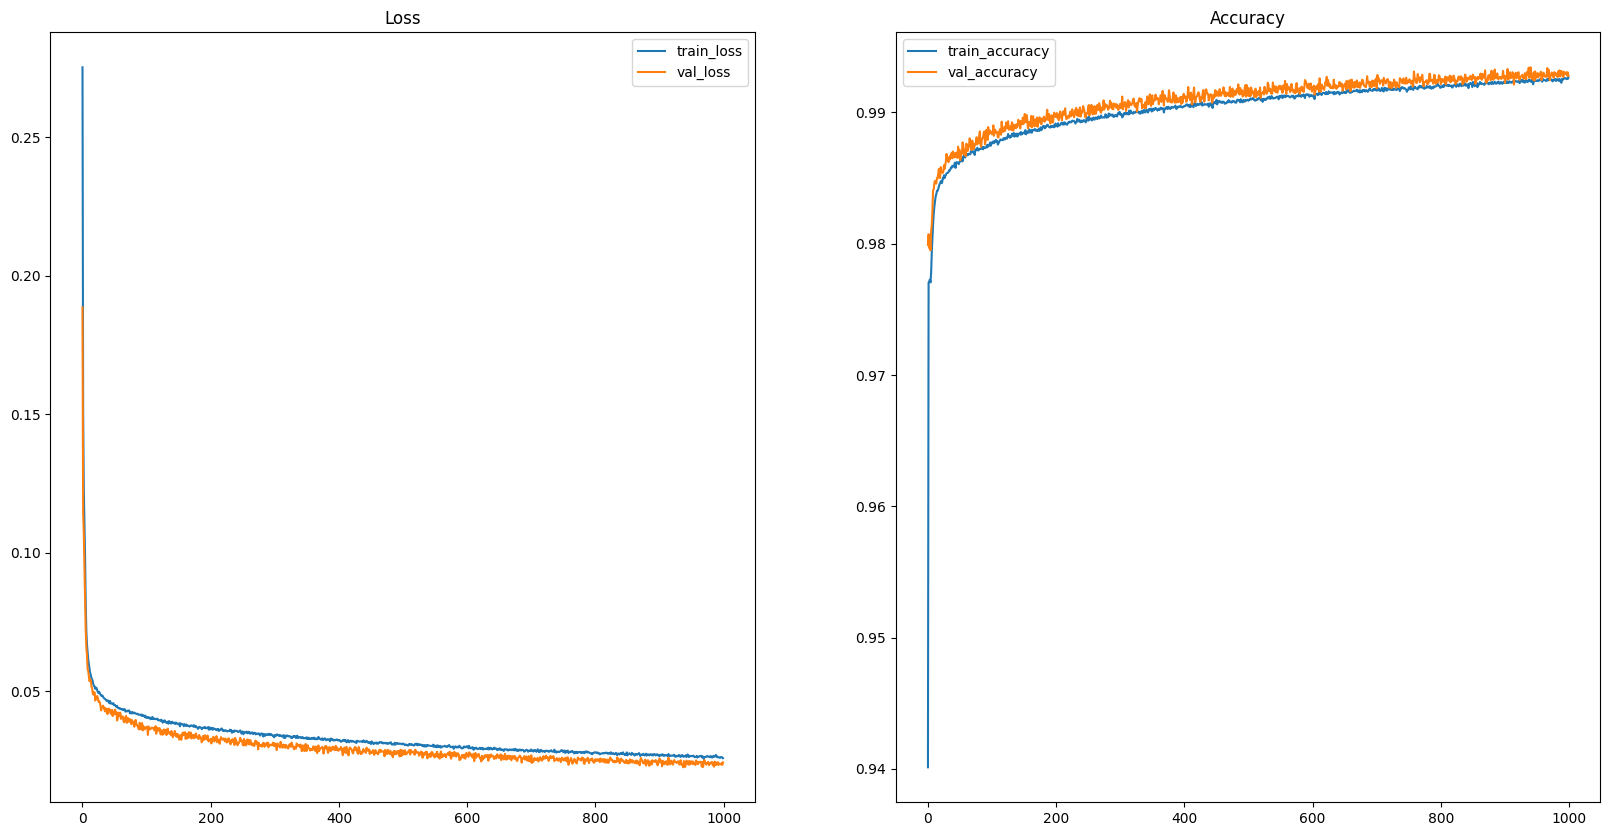

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.plot(train_loss, label="train_loss")
ax1.plot(val_loss, label="val_loss")
ax1.set_title('Loss')
ax1.legend()

ax2.plot(train_accuracy, label="train_accuracy")
ax2.plot(val_accuracy, label="val_accuracy")
ax2.set_title('Accuracy')
ax2.legend()

## 6. Predicting

In [16]:
def predict_image_mask(model, image):
    model.eval()
    image = image.to(device)
    with torch.inference_mode():
        output, _ = model(image.unsqueeze(0))
        masked = torch.argmax(output, dim=1).cpu().squeeze(0)
    return masked

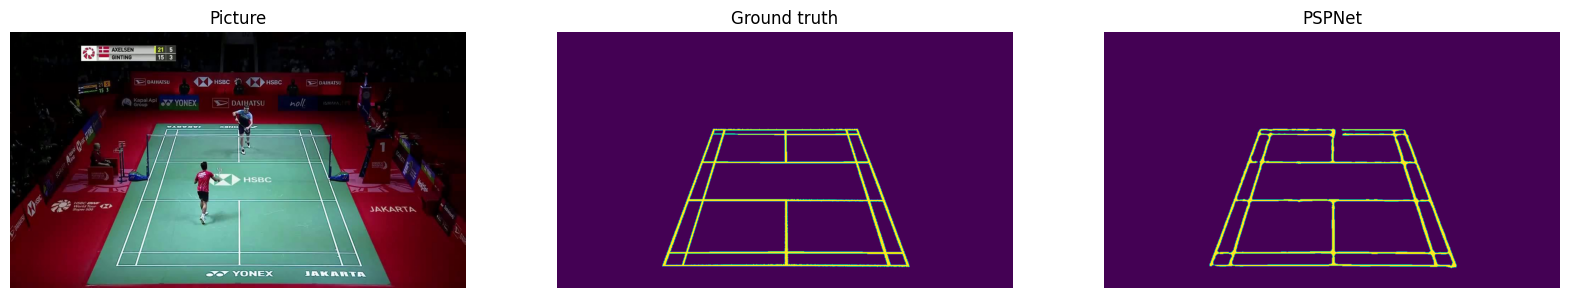

In [22]:
image, mask = test_set[random.randint(0, 26)]
pred_mask = predict_image_mask(model, image)

_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))

ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')
ax1.set_axis_off()

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()

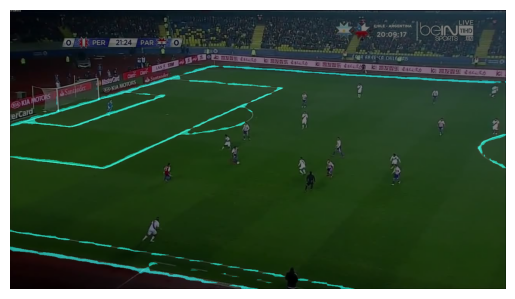

In [25]:
image, _ = test_set[random.randint(0, 26)]
pred_mask = predict_image_mask(model, image)
color_map = [[0, 0, 0], [0, 255, 255]]
rgb_image = torch.tensor([[color_map[val] for val in row] for row in pred_mask]).numpy()

plt.axis('off')
plt.imshow(T.ToPILImage()(image))
plt.imshow(rgb_image, alpha=0.5)

In [19]:
%%time
pred_mask = predict_image_mask(model, image)

CPU times: total: 219 ms
Wall time: 324 ms
